# Data Science Challenge

Problema a resolver:

> Dentro del marketplace existen productos similares o idénticos entre sí (son productos vendidos por distintos sellers, en la api puedes obtener y descargar los títulos e incluso las imágenes!). ¿Cómo buscar dichos ítems para agruparlos y volverlos comparables entre sí? Esto permitiría mejorar la experiencia ante muchas opciones similares.

La solución propuesta compara la información en los títulos o en los atributos de cada producto para encontrar otros productos dentro de la misma subcategoría que se le asemejen. La información contenida en las imágenes de los productos también podría ser útil en este tarea, pero no fue necesaria para obtener este primer prototipo. Además, comparar imágenes incurre en mayores costos de implementación y de computación posteriores. Otro tipo de información que hubiese resultado útil es la de visitas, pero esta no se encuentra disponible en la API pública por lo que pude ver (sí se puede ver cuantas visitas recibió un seller o item, pero no se pueden ver las visitas de cada comprador). La solución propuesta permite filtrar o sopesar los resultados bajo distintos criterios, por ejemplo, si se quiere o no que los productos mostrados sean del mismo seller o marca.

In [175]:
import requests

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn.feature_extraction.text as sktext
import sklearn.neighbors as skneigh
import sklearn.manifold as skmani
import nltk.corpus as corpus

%matplotlib inline

In [176]:
def attr_parser(item_attrs, cat_attrs):
    """
    Función para parsear y ordenar los atributos de cada item
    de acuerdo a los atributos de su categoría.
    
    Parameters
    ----------
    
    items_attrs : list
        Lista con los atributos de cada item.
        Obtenida de f'https://api.mercadolibre.com/items/{item_id}'.
        
    cat_attrs : list
        Lista con los atributos de la categoría.
        Obtenida de f'https://api.mercadolibre.com/categories/{cat_id}/attributes'.
        
    Returns
    -------
    
    parsed : list
        Lista con los atributos del item ordenados según cat_attrs
        y transformado a valores numéricos (floats).
    """
    
    parsed = []
    for base_attr in cat_attrs:
        attr_id = base_attr['id'] 

        # Look for attribute
        attribute_found = False
        for attr in item_attrs:
            if attr['id'] == attr_id:
                value_type = base_attr['value_type']
                try:
                    if   value_type == 'number':
                        parsed.append(float(attr['value_name']))
                    elif value_type == 'number_unit':
                        # TODO: conversor de unidades
                        parsed.append(attr['value_struct']['number']) 
                    elif value_type == 'string':
                        # TODO: apply tokenizer to attribute
                        parsed.append(float(attr['value_id']))
                    elif value_type == 'boolean':
                        parsed.append(1.0 if attr['value_id']=='242085' else 0.0)
                    elif value_type == 'list':
                        # TODO: implement list parsing
                        parsed.append(0.0)
                except:
                    parsed.append(0.0)
                
                attribute_found = True
                break

        # Attribute not found
        if not attribute_found:
            parsed.append(0.0)
    
    return parsed

In [177]:
# Target
site_id = 'MLA' # Argentina

# target_id = f'{site_id}1100783124' # Pila AAA
# target_id = f'{site_id}1101556021' # Multiprocesadora
# target_id = f'{site_id}928959843' # Bar Carrito
target_id = f'{site_id}801358441' # Stereo Auto
# target_id = 'f{site_id}1119449548' # Tablet Samsung

In [178]:
# Get item
# Extract info from target item
url  = f'https://api.mercadolibre.com/items/{target_id}'
req  = requests.get(url)
info = req.json()
target = info['title']

print('Item a buscar:', target)

Item a buscar: Stereo Auto Doble Din Pantalla Tactil Mirrorlink Camara Rev!


Obtengo la categoría y busco sus atributos. Gracias al esfuerzo puestos en generar y mantener un buen árbol de categorías es fácil restringir el universo de búsquedas.

Cabe destacar que funciones de la API tales como _domain discovery_ realizan una tarea similar a la aquí propuesta y sería interesante comparar approaches.

In [179]:
# Get categoy and attributes
cat_id = info['category_id']
url = f'https://api.mercadolibre.com/categories/{cat_id}/attributes'
req = requests.get(url)
cat_attrs = req.json()
target_attr = attr_parser(info['attributes'], cat_attrs)
target_attr = np.array(target_attr).reshape(1,-1)
target_loc  = info['seller_address']['search_location']['state']['id']

In [180]:
# Get items in categories
limit = 50
items = []

url = f'https://api.mercadolibre.com/sites/{site_id}/search?category={cat_id}'
req = requests.get(url)
total = req.json()['paging']['total']

if total>1000: total = 1000 # Sin AUTHTOKEN no deja ver más de 1000 registros
total = 200 ##### Acoto valores

items = items + req.json()['results']
for offset in range(limit, total, limit):
    url = f'https://api.mercadolibre.com/sites/{site_id}/search?category={cat_id}&offset={offset}'
    req = requests.get(url)
    info  = req.json()
    
    items = items + info['results']

Se podría crear un diccionario más grande viendo las descripciones en /items/{item_id}/description

In [181]:
# Extract features from items
titles      = []
item_ids    = []
attributes  = []
for unit in items:
    url  = f'https://api.mercadolibre.com/items/{unit["id"]}'
    req  = requests.get(url)
    info = req.json()
    try:
        # Restricción geográfica
        if info['seller_address']['search_location']['state']['id'] == target_loc:
            item_ids.append(info['id'])
            titles.append(info['title'])
            attributes.append(attr_parser(info['attributes'], cat_attrs))
    except KeyError:
        pass
    
titles     = np.array(titles)
item_ids   = np.array(item_ids)
attributes = np.array(attributes)

Algunos atributos están ordenados y hasta pueden ser contínuos, como el precio, pero otros, como la marca, no. Esto puede tener consecuencias interesantes a la hora de comparar atributos.

In [182]:
# Normalizo atributos
print(np.shape(attributes))
attrs_max = attributes.max(axis=0)
attrs_max[attrs_max==0.0] = 1

(161, 46)


In [183]:
target_attr = target_attr/attrs_max
attributes  = attributes/attrs_max

# Agrupamientos

Ya obtenida la información realizo agrupamientos mediante el método de Nearest Neighbors.

## Agrupamiento por texto

In [184]:
# Tokenizo y normalizo los títulos
count_vect = sktext.CountVectorizer(stop_words=corpus.stopwords.words('spanish'))
tfidf_tran = sktext.TfidfTransformer()

X = count_vect.fit_transform(titles)
X = tfidf_tran.fit_transform(X)

In [185]:
# Armo el mapa
nnalg_text = skneigh.NearestNeighbors()
nnalg_text.fit(X)

NearestNeighbors()

In [186]:
# Realizo la predicción
predict = count_vect.transform([target])
predict = tfidf_tran.transform(predict)
dist_text, res_text = nnalg_text.kneighbors(predict, return_distance=True)

print(np.array(titles)[res_text[0]])
print(dist_text)

['Stereo Auto Doble Din Pantalla Tactil Mirrorlink Camara Rev!'
 'Stereo Auto Doble Din Pantalla Tactil Mirrorlink Camara Rev'
 'Stereo Auto Doble Din Pantalla Tactil Mirrorlink Camara Rev'
 'Stereo Auto Doble Din Pantalla Tactil Mirrorlink Camara Rev!'
 'Stereo Auto Doble Din Pantalla Tactil Mirrorlink Camara Rev']
[[0. 0. 0. 0. 0.]]


In [187]:
total_text_dist, total_text_idxs = nnalg_text.kneighbors(X)

## Agrupamiento por atributos

In [188]:
# Armo el mapa
nnalg_attr = skneigh.NearestNeighbors()
nnalg_attr.fit(attributes)

NearestNeighbors()

In [189]:
# Realizo la predicción
dist_attr, res_attr = nnalg_attr.kneighbors(target_attr, return_distance=True)

print(np.array(titles)[res_attr[0]])
print(dist_attr)

['Stereo Auto 2 Din 7018b Pantalla 7 Tactil Bt + 2 Parlantes !'
 'Stereo Auto Doble Din Pantalla Tactil Mirrorlink Camara Rev!'
 'Stereo Auto Doble Din Pantalla Tactil Camara Rev Cuotas!!'
 'Stereo Auto 2 Din 7018b Pantalla 7 Tactil Bt + 4 Parlantes !'
 'Stereo Auto Doble Din Pantalla Tactil Mirrorlink Camara Rev!']
[[0. 0. 0. 0. 0.]]


In [190]:
total_attr_dist, total_attr_idxs = nnalg_attr.kneighbors(attributes)

## Comparación

Analizo las predicciones de cada agrupamiento sobre todos los productos seleccionados de la categoría.

Text(0, 0.5, 'Predicción')

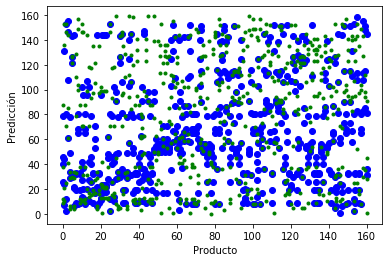

In [191]:
plt.plot(total_attr_idxs[:,1:], 'bo') # Resultados agrupados por texto
plt.plot(total_text_idxs[:,1:], 'g.') # Resultados agrupados por atributos12
plt.xlabel('Producto')
plt.ylabel('Predicción')

In [192]:
# Calculo la correlación entre ambas predicciones
np.sum(np.sort(total_attr_idxs[:,1:])==np.sort(total_text_idxs[:,1:]))/(4*len(titles))

0.09006211180124224

In [193]:
# Veo otro ejemplo
ii = 12
print(np.array(titles)[total_attr_idxs[ii]],'\n',np.array(titles)[total_text_idxs[ii]])

['Stereo Auto Doble Din Pantalla Tactil Mirrorlink Camara Rev'
 'Kit Stereo Pantalla Tactil Para Auto Doble Din + Camara Rev'
 'Stereo Auto Doble Din Pantalla Tactil Mirrorlink Camara Rev!'
 'Stereo Pantalla Rebatible Tactil Bluetooth Dvd 7 Pulgadas'
 'Estereo Android 8.1 Doble Din 7   Bt/wifi/gps Mran7b'] 
 ['Stereo Auto Doble Din Pantalla Tactil Mirrorlink Camara Rev!'
 'Stereo Auto Doble Din Pantalla Tactil Mirrorlink Camara Rev'
 'Stereo Auto Doble Din Pantalla Tactil Mirrorlink Camara Rev'
 'Stereo Auto Doble Din Pantalla Tactil Mirrorlink Camara Rev!'
 'Stereo Auto Doble Din Pantalla Tactil Mirrorlink Camara Rev']


Consideraciones posibles: separar por seller, marca, precio, etc. Esto depende un poco de la estrategia de venta y que se le quiere mostrar al usuario. Se puede implementar desde el mismo algoritmo de Nearest Neighbors pasandole una métrica que pese más o menos a las distintas variables, o post-procesando los resultados también.

Otra forma posible de analizar las predicciones es haciendo una visualización del tipo _t-SNE_.

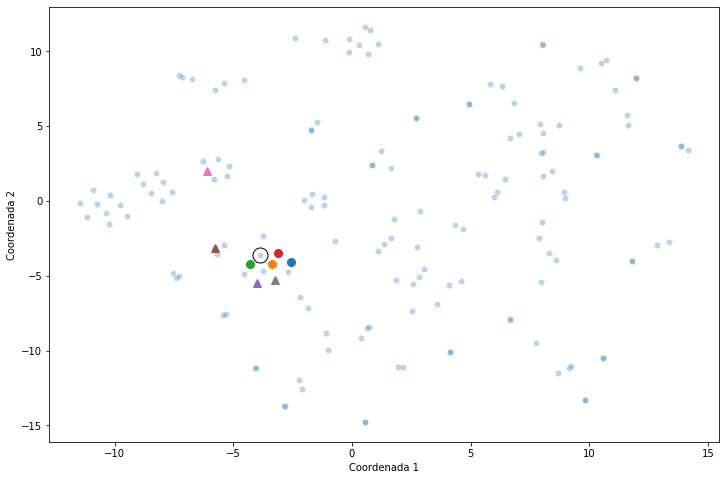

In [194]:
tsne = skmani.TSNE(n_components=2)
tsne_results = tsne.fit_transform(X)
 
data = {}
data['tsne-2d-one'] = tsne_results[:,0]
data['tsne-2d-two'] = tsne_results[:,1]
plt.figure(figsize=(12,8))


sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    palette=sns.color_palette("hls", 10),
    data=data,
    legend="full",
    alpha=0.3
)
plt.xlabel('Coordenada 1')
plt.ylabel('Coordenada 2')

# Agrego las predicciones
ii = res_text[0][0]
plt.plot(data['tsne-2d-one'][ii], data['tsne-2d-two'][ii], 'ko', markersize=15, markerfacecolor='none')

for ii in res_text[0][1:]:
    plt.plot(data['tsne-2d-one'][ii], data['tsne-2d-two'][ii], 'o', markersize=8)
    
for ii in res_attr[0][1:]:
    plt.plot(data['tsne-2d-one'][ii], data['tsne-2d-two'][ii], '^', markersize=8)


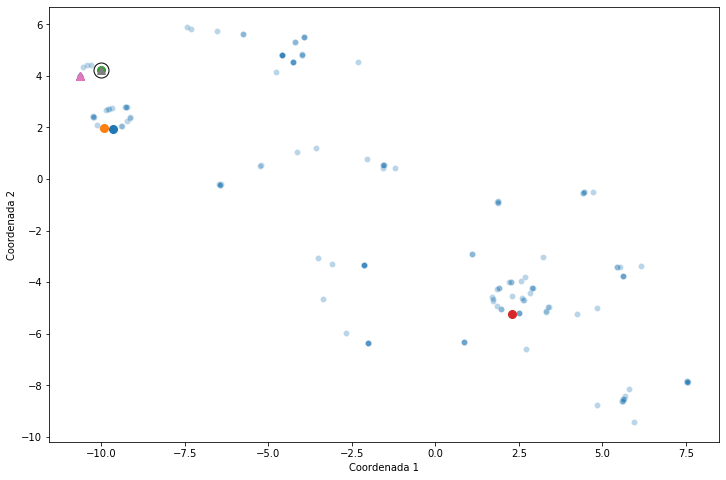

In [195]:
tsne = skmani.TSNE(n_components=2)
tsne_results = tsne.fit_transform(attributes)
 
data = {}
data['tsne-2d-one'] = tsne_results[:,0]
data['tsne-2d-two'] = tsne_results[:,1]
plt.figure(figsize=(12,8))


sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    palette=sns.color_palette("hls", 10),
    data=data,
    legend="full",
    alpha=0.3
)
plt.xlabel('Coordenada 1')
plt.ylabel('Coordenada 2')

# Agrego las predicciones
ii = res_text[0][0]
plt.plot(data['tsne-2d-one'][ii], data['tsne-2d-two'][ii], 'ko', markersize=15, markerfacecolor='none')

for ii in res_text[0][1:]:
    plt.plot(data['tsne-2d-one'][ii], data['tsne-2d-two'][ii], 'o', markersize=8)
    
for ii in res_attr[0][1:]:
    plt.plot(data['tsne-2d-one'][ii], data['tsne-2d-two'][ii], '^', markersize=8)


Podemos observar la existencia de clusters en los datos. Las predicciones obtenidas suelen estar en la vecindad del punto (aunque no sean estrictamente los más cercanos en esta visualización).